E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1497
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0141
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0093
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0071
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0067
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0084
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0085
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0100
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0077
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0080
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0063 
Epoch 12/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0071
Epoch 13/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0070   
Epoch 14/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0059   
Epoch 15/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/st

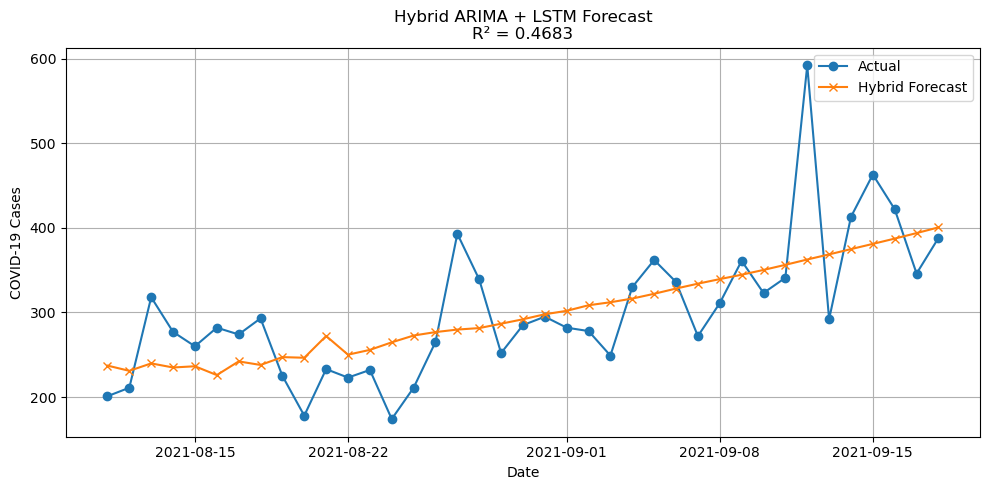

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# === Step 1: Load and prepare data ===
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data = data[(data['Date'] >= '2021-01-04') & (data['Date'] <= '2021-09-18')].reset_index(drop=True)

target_col = 'New deaths COVID-19 Cases'
ts = data.set_index('Date')[target_col]

# === Step 2: Train/test split ===
train_ts = ts[:'2021-08-10']
test_ts = ts['2021-08-11':'2021-09-18']

# === Step 3: Fit best ARIMA model ===
best_order = (0, 3, 2)  # Use your best found (p,d,q) here
arima_model = ARIMA(train_ts, order=best_order).fit()

# === Step 4: Forecast on test set using ARIMA ===
arima_forecast = arima_model.forecast(steps=len(test_ts))
arima_forecast.index = test_ts.index

# === Step 5: Calculate residuals on training data ===
arima_pred_train = arima_model.predict(start=train_ts.index[1], end=train_ts.index[-1])
residuals = train_ts[1:] - arima_pred_train

# === Step 6: Scale residuals and create LSTM sequences ===
scaler = MinMaxScaler()
residuals_scaled = scaler.fit_transform(residuals.values.reshape(-1, 1))

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i - seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

seq_len = 10
x_lstm, y_lstm = create_sequences(residuals_scaled, seq_len)

# === Step 7: Build and train LSTM ===
model = Sequential()
model.add(LSTM(64, input_shape=(seq_len, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_lstm, y_lstm, epochs=200, batch_size=16, verbose=1)

# === Step 8: Predict residuals on test set ===
resid_history = residuals_scaled[-seq_len:].flatten().tolist()
lstm_pred_scaled = []

for _ in range(len(test_ts)):
    input_seq = np.array(resid_history[-seq_len:]).reshape(1, seq_len, 1)
    pred = model.predict(input_seq, verbose=0)[0][0]
    lstm_pred_scaled.append(pred)
    resid_history.append(pred)

lstm_pred_resid = scaler.inverse_transform(np.array(lstm_pred_scaled).reshape(-1, 1)).flatten()

# === Step 9: Final hybrid forecast ===
hybrid_forecast = arima_forecast.values + lstm_pred_resid

# === Step 10: Evaluate hybrid model ===
actual = test_ts.values
mse = mean_squared_error(actual, hybrid_forecast)
mae = mean_absolute_error(actual, hybrid_forecast)
mape = np.mean(np.abs((actual - hybrid_forecast) / actual)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(actual) - np.min(actual))
nrmse = rmse / np.mean(actual)
r2 = r2_score(actual, hybrid_forecast)

print("\n📊 Final Hybrid ARIMA + LSTM Forecast Evaluation:")
print(f"ARIMA Order Used: {best_order}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Relative RMSE (RRMSE): {rrmse:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# === Plot actual vs hybrid forecast ===
plt.figure(figsize=(10, 5))
plt.plot(test_ts.index, actual, label='Actual', marker='o')
plt.plot(test_ts.index, hybrid_forecast, label='Hybrid Forecast', marker='x')
plt.title(f"Hybrid ARIMA + LSTM Forecast\nR² = {r2:.4f}")
plt.xlabel("Date")
plt.ylabel("COVID-19 Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
# === Extract hybrid forecast for 12/9/21 to 18/9/21 ===
forecast_range = pd.date_range(start='2021-09-12', end='2021-09-18')
hybrid_forecast_series = pd.Series(hybrid_forecast, index=test_ts.index)
selected_forecast = hybrid_forecast_series.loc[forecast_range]

# Print forecasted values for the selected range
print("\n📅 Hybrid Forecast: 12/09/2021 to 18/09/2021")
print(selected_forecast.round(0).astype(int))



📅 Hybrid Forecast: 12/09/2021 to 18/09/2021
2021-09-12    363
2021-09-13    369
2021-09-14    375
2021-09-15    381
2021-09-16    387
2021-09-17    394
2021-09-18    401
dtype: int32


23:42:41 - cmdstanpy - INFO - Chain [1] start processing
23:42:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error (MSE): 6655.66
Mean Absolute Error (MAE): 60.44
Mean Absolute Percentage Error (MAPE): 18.13%
Root Mean Squared Error (RMSE): 81.58
Relative RMSE (RRMSE): 0.1952
Normalized RMSE (NRMSE): 0.2700
R-squared (R²): 0.0018


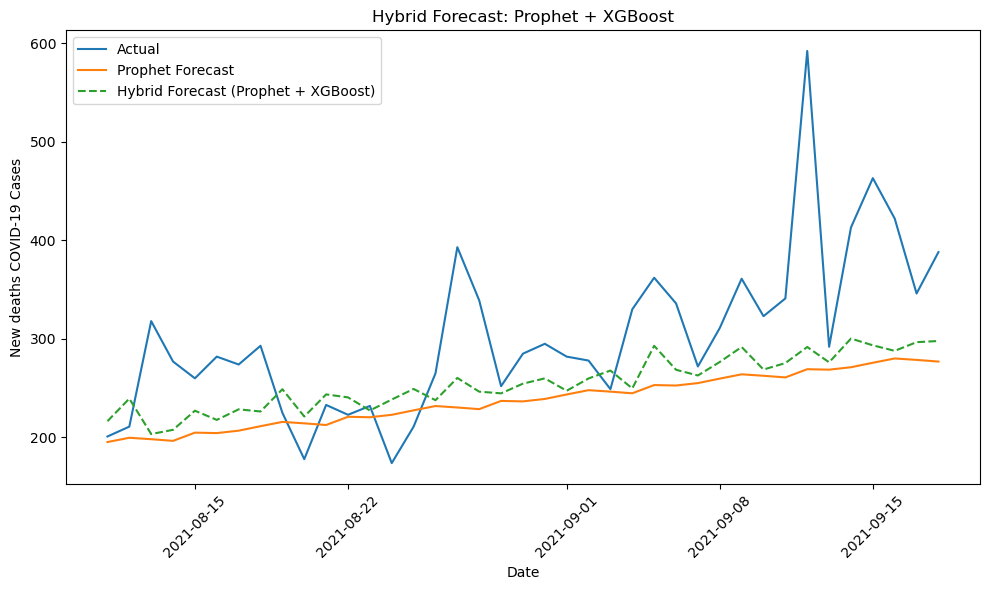


📈 Hybrid Prophet + XGBoost Forecast (12–18 Sept 2021):
         Date  Actual     Prophet  Hybrid_Forecast
32 2021-09-12     592  269.236901       291.758191
33 2021-09-13     292  268.771234       276.218716
34 2021-09-14     413  271.238528       300.303639
35 2021-09-15     463  275.775216       293.455146
36 2021-09-16     422  280.134734       287.858056
37 2021-09-17     346  278.671422       296.656262
38 2021-09-18     388  276.981664       297.846221


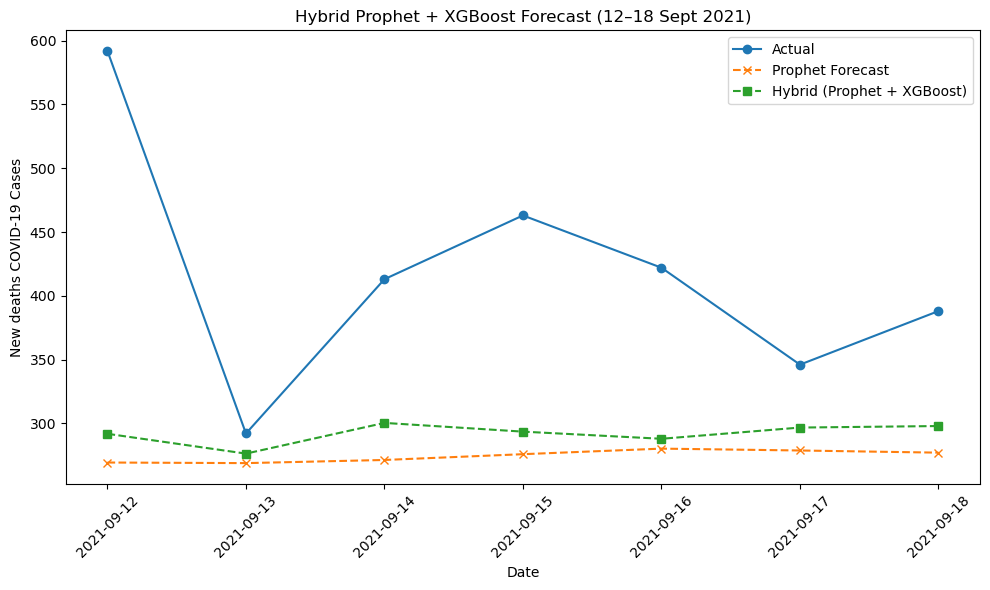

In [3]:
 import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

# === Load your data ===
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
data['Date'] = pd.to_datetime(data['Date'])
data = data[(data['Date'] >= '2021-01-04') & (data['Date'] <= '2021-09-18')].reset_index(drop=True)

# === Prepare for Prophet ===
df_prophet = data[['Date', 'New deaths COVID-19 Cases']].rename(columns={'Date': 'ds', 'New deaths COVID-19 Cases': 'y'})

# === Split into train and test sets ===
train_end = '2021-08-10'
test_start = '2021-08-11'
test_end = '2021-09-18'

train_df = df_prophet[df_prophet['ds'] <= train_end].copy()
test_df = df_prophet[(df_prophet['ds'] >= test_start) & (df_prophet['ds'] <= test_end)].copy()

# === Step 1: Fit Prophet model ===
model = Prophet(daily_seasonality=True)
model.fit(train_df)

future = model.make_future_dataframe(periods=len(test_df), freq='D')
forecast = model.predict(future)

# === Step 2: Calculate residuals from training data ===
train_pred = forecast[['ds', 'yhat']].iloc[:len(train_df)].reset_index(drop=True)
train_df = train_df.reset_index(drop=True)
train_df['residual'] = train_df['y'] - train_pred['yhat']

# === Step 3: Create lag features for XGBoost ===
lags = 3
for i in range(1, lags + 1):
    train_df[f'lag{i}'] = train_df['residual'].shift(i)

train_df.dropna(inplace=True)

X_train = train_df[[f'lag{i}' for i in range(1, lags + 1)]]
y_train = train_df['residual']

# === Step 4: Train XGBoost on residuals ===
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model_xgb.fit(X_train, y_train)

# === Step 5: Predict residuals for test period ===
last_known = train_df[['residual'] + [f'lag{i}' for i in range(1, lags + 1)]].iloc[-1]
lag_values = [last_known[f'lag{i}'] for i in range(1, lags + 1)]
predicted_residuals = []

for _ in range(len(test_df)):
    x_input = np.array(lag_values).reshape(1, -1)
    pred_resid = model_xgb.predict(x_input)[0]
    predicted_residuals.append(pred_resid)

    # update lag values
    lag_values = lag_values[1:] + [pred_resid]

# === Step 6: Combine with Prophet forecast ===
prophet_forecast = forecast['yhat'].iloc[-len(test_df):].values
hybrid_forecast = prophet_forecast + np.array(predicted_residuals)
actual = test_df['y'].values

# === Step 7: Evaluation ===
mse = mean_squared_error(actual, hybrid_forecast)
mae = mean_absolute_error(actual, hybrid_forecast)
mape = np.mean(np.abs((actual - hybrid_forecast) / actual)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(actual) - np.min(actual))
nrmse = rmse / np.mean(actual)
r2 = r2_score(actual, hybrid_forecast)


print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Relative RMSE (RRMSE): {rrmse:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# === Step 8: Plot results ===
plt.figure(figsize=(10, 6))
plt.plot(test_df['ds'], actual, label='Actual')
plt.plot(test_df['ds'], prophet_forecast, label='Prophet Forecast')
plt.plot(test_df['ds'], hybrid_forecast, label='Hybrid Forecast (Prophet + XGBoost)', linestyle='--')
plt.title('Hybrid Forecast: Prophet + XGBoost')
plt.xlabel('Date')
plt.ylabel('New deaths COVID-19 Cases')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
# === Step 9: Extract forecast for 12–18 Sept 2021 ===
forecast_horizon = pd.date_range(start="2021-09-12", end="2021-09-18")

results_df = pd.DataFrame({
    "Date": test_df['ds'].values,
    "Actual": actual,
    "Prophet": prophet_forecast,
    "Hybrid_Forecast": hybrid_forecast
})

# Filter only 12–18 Sept 2021
results_subset = results_df[results_df["Date"].isin(forecast_horizon)]

print("\n📈 Hybrid Prophet + XGBoost Forecast (12–18 Sept 2021):")
print(results_subset)

# === Plot only 12–18 Sept 2021 ===
plt.figure(figsize=(10, 6))
plt.plot(results_subset["Date"], results_subset["Actual"], marker='o', label="Actual")
plt.plot(results_subset["Date"], results_subset["Prophet"], marker='x', linestyle="--", label="Prophet Forecast")
plt.plot(results_subset["Date"], results_subset["Hybrid_Forecast"], marker='s', linestyle="--", label="Hybrid (Prophet + XGBoost)")
plt.title("Hybrid Prophet + XGBoost Forecast (12–18 Sept 2021)")
plt.xlabel("Date")
plt.ylabel("New deaths COVID-19 Cases")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ================================
# 1. Load and prepare the dataset
# ================================
df = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")

# Ensure proper column names
df.rename(columns={"Date": "ds", "New deaths COVID-19 Cases": "y"}, inplace=True)

# Sort by date
df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values("ds")

# ================================
# 2. Train/Validation/Test Split
# ================================
train = df[(df['ds'] >= "2021-01-04") & (df['ds'] <= "2021-07-02")]
val   = df[(df['ds'] >= "2021-07-03") & (df['ds'] <= "2021-08-10")]
test  = df[(df['ds'] >= "2021-08-11") & (df['ds'] <= "2021-09-18")]

# Target variable
y_train = train['y']
y_val = val['y']
y_test = test['y']

# ================================
# 3. ARIMA Model
# ================================
arima_model = ARIMA(y_train, order=(0,3,2))  # you can tune p,d,q
arima_fit = arima_model.fit()

# Forecast including validation + test
arima_forecast = arima_fit.predict(start=len(y_train), end=len(y_train)+len(y_val)+len(y_test)-1)

# ================================
# 4. Prophet Model
# ================================
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(train)

future = prophet_model.make_future_dataframe(periods=len(val)+len(test))
prophet_forecast = prophet_model.predict(future)
prophet_pred = prophet_forecast.iloc[-(len(val)+len(test)):, :]["yhat"].values

# ================================
# 5. Hybrid Forecast (Average)
# ================================
hybrid_forecast = (arima_forecast.values + prophet_pred) / 2

# Align with actual test data
actual = pd.concat([y_val, y_test]).reset_index(drop=True)
preds = pd.Series(hybrid_forecast, index=actual.index)

# ================================
# 6. Error Metrics
# ================================
mse = mean_squared_error(actual, hybrid_forecast)
mae = mean_absolute_error(actual, hybrid_forecast)
mape = np.mean(np.abs((actual - hybrid_forecast) / actual)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(actual) - np.min(actual))
nrmse = rmse / np.mean(actual)
r2 = r2_score(actual, hybrid_forecast)


print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Relative RMSE (RRMSE): {rrmse:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")
# ================================
# 7. Predict for 12/9/21 → 18/9/21
# ================================
future_dates = pd.date_range("2021-09-12", "2021-09-18")

# ARIMA rolling forecast for test set
arima_pred_test = arima_fit.predict(start=len(y_train)+len(y_val), end=len(y_train)+len(y_val)+len(y_test)-1)

# Prophet forecast already includes full range
prophet_test_pred = prophet_pred[-len(y_test):]

# Hybrid for test period
hybrid_test_pred = (arima_pred_test.values + prophet_test_pred) / 2

# Match only 12–18 Sep 2021
forecast_df = pd.DataFrame({
    "Date": test['ds'].values,
    "Actual": test['y'].values,
    "ARIMA_Pred": arima_pred_test.values,
    "Prophet_Pred": prophet_test_pred,
    "Hybrid_Pred": hybrid_test_pred
})

forecast_df = forecast_df[(forecast_df["Date"] >= "2021-09-12") & (forecast_df["Date"] <= "2021-09-18")]
print("\nForecast (12/09/2021 → 18/09/2021):")
print(forecast_df)


E:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
23:43:59 - cmdstanpy - INFO - Chain [1] start processing
23:43:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error (MSE): 37708.75
Mean Absolute Error (MAE): 133.22
Mean Absolute Percentage Error (MAPE): 49.60%
Root Mean Squared Error (RMSE): 194.19
Relative RMSE (RRMSE): 0.3671
Normalized RMSE (NRMSE): 0.8661
R-squared (R²): -2.3918

Forecast (12/09/2021 → 18/09/2021):
         Date  Actual   ARIMA_Pred  Prophet_Pred  Hybrid_Pred
32 2021-09-12     592  1323.116003    174.130438   748.623221
33 2021-09-13     292  1361.049800    171.388591   766.219196
34 2021-09-14     413  1399.551375    172.282576   785.916975
35 2021-09-15     463  1438.620726    177.993116   808.306921
36 2021-09-16     422  1478.257853    178.482681   828.370267
37 2021-09-17     346  1518.462758    179.278623   848.870690
38 2021-09-18     388  1559.235439    180.317319   869.776379


E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Epoch 1/50


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2074
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0120
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0141
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0115
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0080    
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0093
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0088
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0096
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0076
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0073
Epoch 15/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0081
Epoch 16/50
13/13 ━

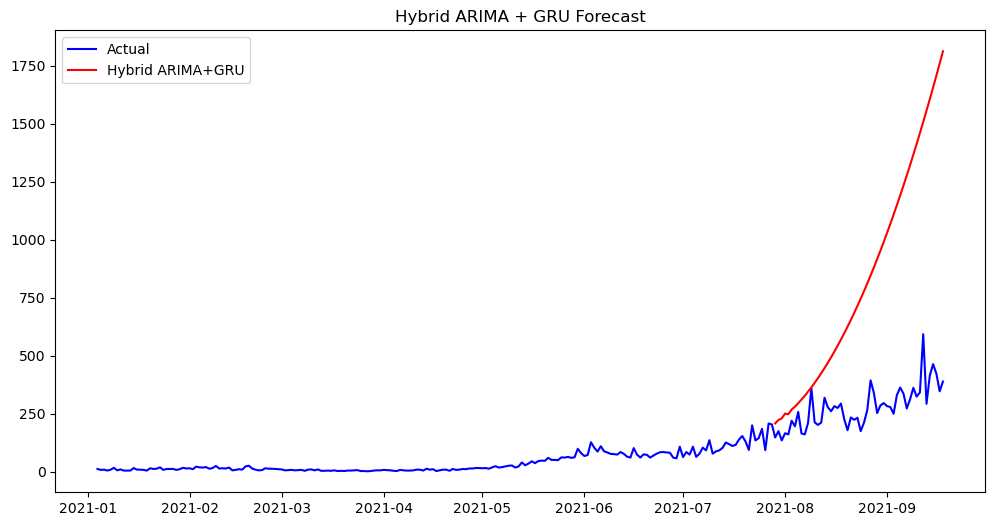


📌 Forecast (12/09/2021 → 18/09/2021):
         Date  Actual  Hybrid_Pred
45 2021-09-12   592.0  1507.225418
46 2021-09-13   292.0  1555.884719
47 2021-09-14   413.0  1605.400698
48 2021-09-15   463.0  1655.773334
49 2021-09-16   422.0  1707.002635
50 2021-09-17   346.0  1759.088606
51 2021-09-18   388.0  1812.031235


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam

# -------------------------------
# 1. Load your data
# -------------------------------
df = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

series = df['New deaths COVID-19 Cases'].astype(float)

# -------------------------------
# 2. Train-Test Split
# -------------------------------
train_size = int(len(series) * 0.8)
train, test = series.iloc[:train_size], series.iloc[train_size:]

# -------------------------------
# 3. Fit ARIMA model
# -------------------------------
arima_order = (0, 3, 2)   # can be tuned
arima_model = ARIMA(train, order=arima_order)
arima_fit = arima_model.fit()

# Predict with ARIMA
arima_pred = arima_fit.predict(start=len(train), end=len(train)+len(test)-1)

# -------------------------------
# 4. Compute residuals
# -------------------------------
residuals = train - arima_fit.fittedvalues
residuals = residuals.dropna()

# -------------------------------
# 5. Prepare residuals for GRU
# -------------------------------
scaler = MinMaxScaler()
residuals_scaled = scaler.fit_transform(residuals.values.reshape(-1, 1))

def create_sequences(data, timesteps=5):
    X, y = [], []
    for i in range(len(data)-timesteps):
        X.append(data[i:i+timesteps])
        y.append(data[i+timesteps])
    return np.array(X), np.array(y)

timesteps = 5
X, y = create_sequences(residuals_scaled, timesteps)
X = X.reshape((X.shape[0], X.shape[1], 1))

# -------------------------------
# 6. Build GRU model
# -------------------------------
gru_model = Sequential([
    GRU(64, input_shape=(timesteps,1), return_sequences=False),
    Dense(1)
])
gru_model.compile(optimizer=Adam(0.001), loss='mse')

gru_model.fit(X, y, epochs=50, batch_size=16, verbose=1)

# -------------------------------
# 7. Forecast residuals with GRU
# -------------------------------
test_residuals = []
last_sequence = residuals_scaled[-timesteps:]

for i in range(len(test)):
    seq_input = last_sequence.reshape((1, timesteps, 1))
    pred_res = gru_model.predict(seq_input, verbose=0)
    test_residuals.append(pred_res[0,0])
    last_sequence = np.append(last_sequence[1:], pred_res[0,0])
    
test_residuals = scaler.inverse_transform(np.array(test_residuals).reshape(-1,1)).flatten()

# -------------------------------
# 8. Hybrid Forecast
# -------------------------------
hybrid_pred = arima_pred.values + test_residuals

# -------------------------------
# 9. Evaluation
actual = test.values
hybrid_forecast = hybrid_pred

mse = mean_squared_error(actual, hybrid_forecast)
mae = mean_absolute_error(actual, hybrid_forecast)
mape = np.mean(np.abs((actual - hybrid_forecast) / actual)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(actual) - np.min(actual))
nrmse = rmse / np.mean(actual)
r2 = r2_score(actual, hybrid_forecast)


print("\n📊 Final Hybrid ARIMA+GRU Forecast Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Relative RMSE (RRMSE): {rrmse:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# -------------------------------
# 10. Visualization
# -------------------------------
plt.figure(figsize=(12,6))
plt.plot(series.index, series, label="Actual", color='blue')
plt.plot(test.index, hybrid_pred, label="Hybrid ARIMA+GRU", color='red')
plt.legend()
plt.title("Hybrid ARIMA + GRU Forecast")
plt.show()

# -------------------------------
# 11. Forecast for 12/09/2021 → 18/09/2021
# -------------------------------
# 11. Forecast for 12/09/2021 → 18/09/2021
# -------------------------------
# -------------------------------
# 11. Forecast for 12/09/2021 → 18/09/2021
# -------------------------------
forecast_df = pd.DataFrame({
    "Date": test.index,
    "Actual": test.values,
       # residual forecast (can be shown separately)
    "Hybrid_Pred": hybrid_pred      # ARIMA + GRU
}).reset_index(drop=True)

# Filter only 12–18 Sep 2021
forecast_df = forecast_df[(forecast_df["Date"] >= "2021-09-12") & (forecast_df["Date"] <= "2021-09-18")]

print("\n📌 Forecast (12/09/2021 → 18/09/2021):")
print(forecast_df)



E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                   SARIMAX Results                                   
Dep. Variable:     New deaths COVID-19 Cases   No. Observations:                  219
Model:                        ARIMA(0, 3, 2)   Log Likelihood               -1014.622
Date:                       Sun, 28 Sep 2025   AIC                           2035.245
Time:                               13:07:12   BIC                           2045.370
Sample:                           01-04-2021   HQIC                          2039.336
                                - 08-10-2021                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9974      0.573     -3.486      0.000      -3.121      -0.874
ma.L2          0.9996      0.574      1.743      0.081      -0.125       2.

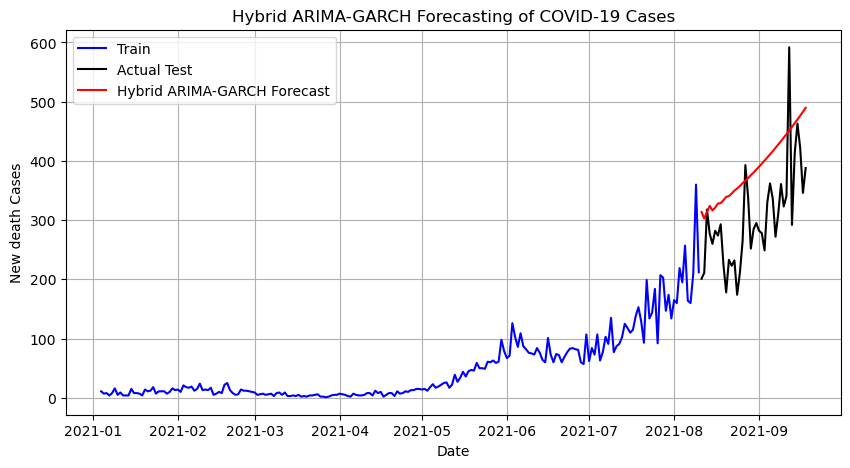

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==============================
# Step 1: Load & preprocess data
# ==============================
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx", 
                     parse_dates=['Date'], index_col='Date')

# Target time series
series = data['New deaths COVID-19 Cases']

# Train-test split (adjust dates if needed)
train = series['2021-01-04':'2021-08-10']
test = series['2021-08-11':'2021-09-18']

# ==============================
# Step 2: Fit ARIMA model
# ==============================
arima_model = ARIMA(train, order=(0,3,2))
arima_fit = arima_model.fit()
print(arima_fit.summary())

# Get residuals
residuals = arima_fit.resid

# ==============================
# Step 3: Fit GARCH on residuals
# ==============================
garch = arch_model(residuals, vol='GARCH', p=7, q=6)
garch_fit = garch.fit(disp="off")
print(garch_fit.summary())

# ==============================
# Step 4: Forecast
# ==============================
# ARIMA forecast
arima_forecast = arima_fit.forecast(steps=len(test))

# GARCH forecast (volatility)
garch_forecast = garch_fit.forecast(horizon=len(test))
garch_vol = garch_forecast.variance.values[-1] ** 0.5  # std dev forecast

# Hybrid forecast = ARIMA forecast + GARCH volatility adjustment
hybrid_forecast = arima_forecast + garch_vol

# Convert to pandas series
hybrid_forecast = pd.Series(hybrid_forecast, index=test.index)

# ==============================
# 9. Evaluation
# ==============================
# 9. Evaluation
# ==============================
actual = test.values
predicted = hybrid_forecast.values  # use hybrid_forecast from above

mse = mean_squared_error(actual, predicted)
mae = mean_absolute_error(actual, predicted)
mape = np.mean(np.abs((actual - predicted) / actual)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(actual) - np.min(actual))
nrmse = rmse / np.mean(actual)
r2 = r2_score(actual, predicted)

print("\n📊 Final Hybrid ARIMA+GARCH Forecast Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Relative RMSE (RRMSE): {rrmse:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# ==============================
# Step 6: Plot
# ==============================
plt.figure(figsize=(10,5))
plt.plot(train.index, train, label="Train", color="blue")
plt.plot(test.index, test, label="Actual Test", color="black")
plt.plot(hybrid_forecast.index, hybrid_forecast, 
         label="Hybrid ARIMA-GARCH Forecast", color="red")

plt.title("Hybrid ARIMA-GARCH Forecasting of COVID-19 Cases")
plt.xlabel("Date")
plt.ylabel("New death Cases")
plt.legend()
plt.grid(True)
plt.show()


Hybrid ARIMA-GARCH Forecast (12–18 Sept 2021):
Date
2021-09-12    451.288449
2021-09-13    457.429879
2021-09-14    463.659200
2021-09-15    469.992817
2021-09-16    476.428066
2021-09-17    482.959469
2021-09-18    489.589955
Name: predicted_mean, dtype: float64


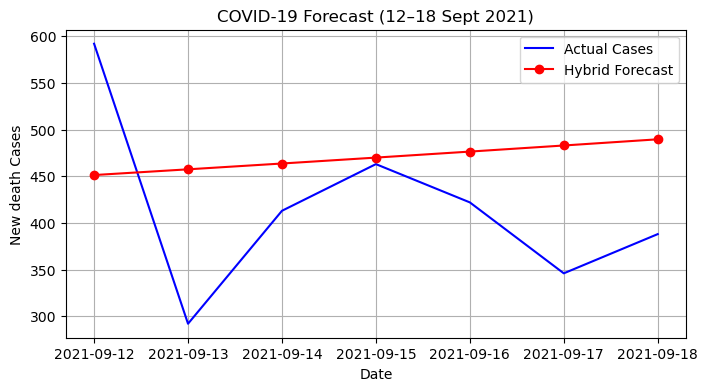

In [8]:
# Select forecast window
forecast_window = hybrid_forecast['2021-09-12':'2021-09-18']
actual_window = test['2021-09-12':'2021-09-18']

print("Hybrid ARIMA-GARCH Forecast (12–18 Sept 2021):")
print(forecast_window)

# Plot actual vs forecast for just that window
plt.figure(figsize=(8,4))
plt.plot(actual_window.index, actual_window, label="Actual Cases", color="blue")
plt.plot(forecast_window.index, forecast_window, label="Hybrid Forecast", color="red", marker='o')

plt.title("COVID-19 Forecast (12–18 Sept 2021)")
plt.xlabel("Date")
plt.ylabel("New death Cases")
plt.legend()
plt.grid(True)
plt.show()



Hybrid ARIMA-XGBoost Forecast Evaluation:
Mean Squared Error (MSE): 3885.95
Mean Absolute Error (MAE): 47.14
Mean Absolute Percentage Error (MAPE): 16.04%
Root Mean Squared Error (RMSE): 62.34
Relative RMSE (RRMSE): 0.1491
Normalized RMSE (NRMSE): 0.2063
R-squared (R²): 0.4172


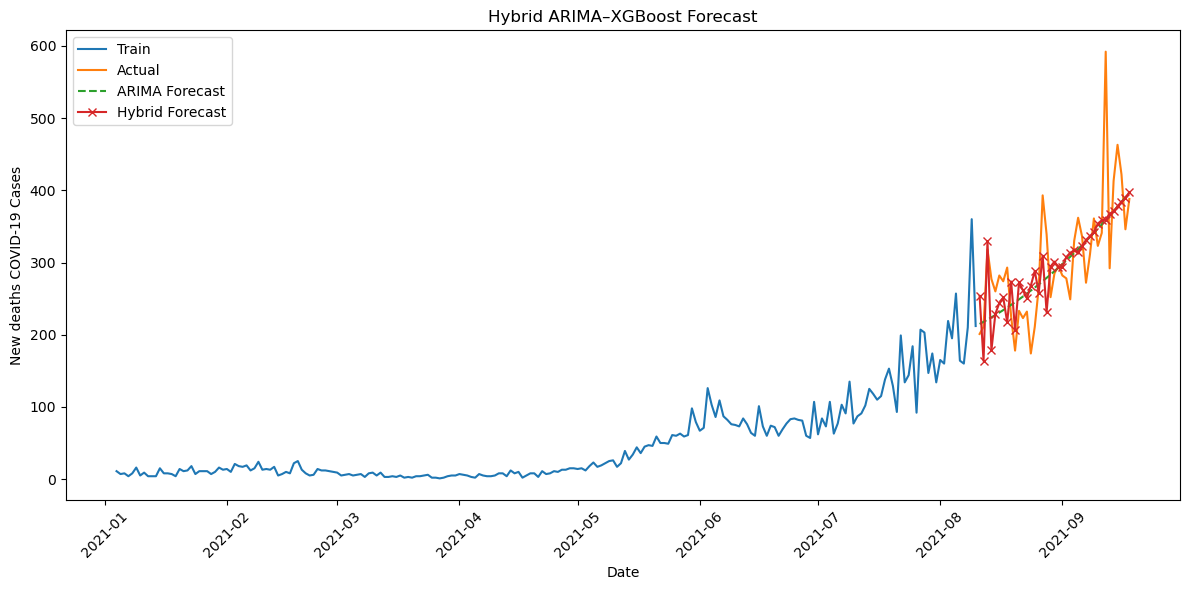


📌 Hybrid ARIMA–XGBoost Forecast (12–18 Sept 2021):
          Date  Actual  ARIMA_Forecast  Hybrid_Forecast
251 2021-09-12     592      358.758314       359.147233
252 2021-09-13     292      364.890835       367.713203
253 2021-09-14     413      371.122492       370.749402
254 2021-09-15     463      377.453284       377.747768
255 2021-09-16     422      383.883211       384.237116
256 2021-09-17     346      390.412273       388.920068
257 2021-09-18     388      397.040471       397.129767


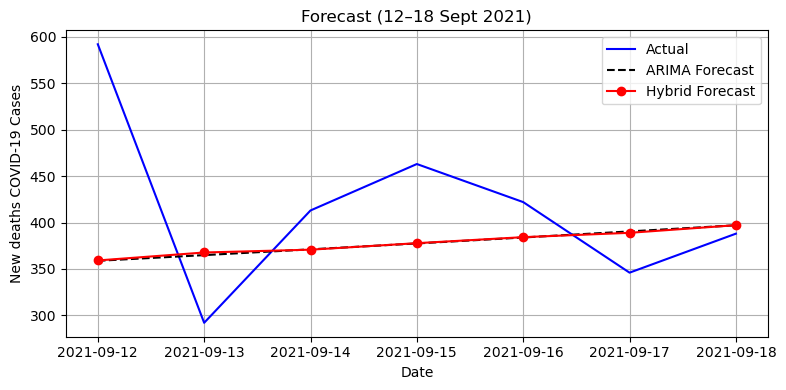

In [9]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# === Load your data ===
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
data = data.rename(columns={'New deaths COVID-19 Cases': 'y'})
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date').reset_index(drop=True)

# === Train/Validation/Test split ===
train_end = '2021-08-10'
test_start = '2021-08-11'
test_end = '2021-09-18'

train_data = data[(data['Date'] <= train_end)]
test_data = data[(data['Date'] >= test_start) & (data['Date'] <= test_end)]

# === Step 1: ARIMA model ===
arima_model = ARIMA(train_data['y'], order=(0,3,2))  # adjust (p,d,q)
arima_fit = arima_model.fit()

# Forecast ARIMA on test period
arima_forecast = arima_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1, dynamic=False)

# Compute residuals (train)
arima_fitted = arima_fit.fittedvalues
residuals = train_data['y'] - arima_fitted

# === Step 2: Train XGBoost on residuals ===
# Create lag features
def create_lags(series, lags=[1,2,3,7,14]):
    df = pd.DataFrame({'resid': series})
    for lag in lags:
        df[f'lag_{lag}'] = df['resid'].shift(lag)
    return df.dropna()

lags = [1,2,3,7,14]
resid_lags = create_lags(residuals, lags=lags)

X_resid = resid_lags.drop('resid', axis=1)
y_resid = resid_lags['resid']

# Train XGBoost
xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb.fit(X_resid, y_resid)

# === Step 3: Forecast residuals on test set ===
# Build lagged residuals from ARIMA forecast errors (recursive prediction)
test_resid_preds = []
prev_resids = list(residuals[-max(lags):])  # last known residuals

for _ in range(len(test_data)):
    # Build input vector
    input_feats = [prev_resids[-lag] for lag in lags]
    input_df = pd.DataFrame([input_feats], columns=[f'lag_{lag}' for lag in lags])
    
    # Predict next residual
    next_resid = xgb.predict(input_df)[0]
    test_resid_preds.append(next_resid)
    
    # Append for recursive usage
    prev_resids.append(next_resid)

# === Step 4: Hybrid Forecast ===
hybrid_forecast = arima_forecast.values + np.array(test_resid_preds)

# === Evaluation ===
# === Evaluation (Hybrid Forecast vs Actual) ===
y_true = test_data['y'].values
forecast = hybrid_forecast  # rename for clarity

mse = mean_squared_error(y_true, forecast)
mae = mean_absolute_error(y_true, forecast)
mape = np.mean(np.abs((y_true - forecast) / y_true)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(y_true) - np.min(y_true))   # relative to range
nrmse = rmse / np.mean(y_true)                     # relative to mean
r2 = r2_score(y_true, forecast)

# Print results
print("\nHybrid ARIMA-XGBoost Forecast Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Relative RMSE (RRMSE): {rrmse:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


# === Plot Actual vs Forecast ===
plt.figure(figsize=(12,6))
plt.plot(train_data['Date'], train_data['y'], label="Train")
plt.plot(test_data['Date'], y_true, label="Actual")
plt.plot(test_data['Date'], arima_forecast, label="ARIMA Forecast", linestyle="--")
plt.plot(test_data['Date'], hybrid_forecast, label="Hybrid Forecast", marker='x')
plt.legend()
plt.xlabel("Date")
plt.ylabel("New deaths COVID-19 Cases")
plt.title("Hybrid ARIMA–XGBoost Forecast")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# ==============================
# Forecast window: 12/09/2021 → 18/09/2021
# ==============================
forecast_df = pd.DataFrame({
    "Date": test_data['Date'].values,
    "Actual": y_true,
    "ARIMA_Forecast": arima_forecast,
    "Hybrid_Forecast": hybrid_forecast
})

# Select only 12–18 Sept 2021
mask = (forecast_df['Date'] >= "2021-09-12") & (forecast_df['Date'] <= "2021-09-18")
forecast_window = forecast_df.loc[mask]

print("\n📌 Hybrid ARIMA–XGBoost Forecast (12–18 Sept 2021):")
print(forecast_window)

# Plot zoomed window
plt.figure(figsize=(8,4))
plt.plot(forecast_window['Date'], forecast_window['Actual'], label="Actual", color="blue")
plt.plot(forecast_window['Date'], forecast_window['ARIMA_Forecast'], 
         label="ARIMA Forecast", linestyle="--", color="black")
plt.plot(forecast_window['Date'], forecast_window['Hybrid_Forecast'], 
         label="Hybrid Forecast", marker="o", color="red")
plt.legend()
plt.xlabel("Date")
plt.ylabel("New deaths COVID-19 Cases")
plt.title("Forecast (12–18 Sept 2021)")
plt.grid(True)
plt.tight_layout()
plt.show()


E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Hybrid ARIMA–SVR Performance:
MSE: 3592.10
MAE: 43.65
MAPE: 14.44%
RMSE: 59.93
RRMSE: 0.1434
NRMSE: 0.1984
R²: 0.4613


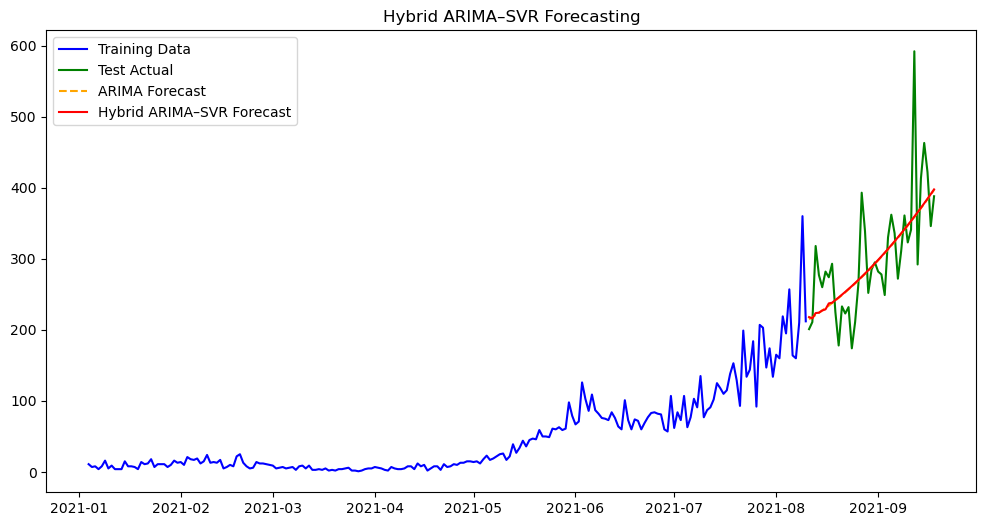

Hybrid ARIMA–SVR Forecast (12–18 Sept 2021):
2021-09-12    359.335700
2021-09-13    365.468221
2021-09-14    371.699878
2021-09-15    378.030670
2021-09-16    384.460597
2021-09-17    390.989660
2021-09-18    397.617857
Freq: D, dtype: float64


In [10]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# === Step 1: Load and preprocess data ===
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data_filtered = data[(data['Date'] >= '2021-01-04') & (data['Date'] <= '2021-09-18')].reset_index(drop=True)

# Set time series
covid_cases_ts = data_filtered.set_index('Date')['New deaths COVID-19 Cases']

# === Step 2: Train ARIMA model (linear component) ===
train_series = covid_cases_ts['2021-01-04':'2021-08-10']  # train+val
test_series = covid_cases_ts['2021-08-11':'2021-09-18']

arima_model = ARIMA(train_series, order=(0,3,2))  # Example order
arima_fit = arima_model.fit()

# In-sample fitted values
arima_fitted = arima_fit.fittedvalues
residuals = train_series - arima_fitted

# === Step 3: Prepare residuals for SVR (nonlinear component) ===
# Explicitly name the residuals column
residuals_df = pd.DataFrame(residuals, columns=["residuals"])

# Create lag features
for lag in range(1, 8):  # last 7 lags
    residuals_df[f"lag_{lag}"] = residuals_df["residuals"].shift(lag)

residuals_df = residuals_df.dropna()

# Features & target for SVR
X_res = residuals_df.drop(columns=["residuals"]).values
y_res = residuals_df["residuals"].values

# Scale features
scaler = MinMaxScaler()
X_res = scaler.fit_transform(X_res)

# Train SVR
svr_model = SVR(kernel="rbf", C=100, gamma=0.01, epsilon=50)
svr_model.fit(X_res, y_res)

# === Step 4: Forecast with ARIMA + SVR ===
arima_forecast = arima_fit.forecast(steps=len(test_series))

# Build SVR input for test period residual prediction
resid_values = residuals.tolist()
svr_preds = []

for i in range(len(test_series)):
    last_lags = np.array(resid_values[-7:]).reshape(1, -1)  # last 7 residuals
    last_lags_scaled = scaler.transform(last_lags)
    svr_pred = svr_model.predict(last_lags_scaled)[0]
    svr_preds.append(svr_pred)
    resid_values.append(svr_pred)  # update with predicted residual

svr_preds = pd.Series(svr_preds, index=test_series.index)

# Hybrid forecast = ARIMA forecast + SVR residual forecast
hybrid_forecast = arima_forecast + svr_preds

# === Step 5: Evaluate ===
mse = mean_squared_error(test_series, hybrid_forecast)
mae = mean_absolute_error(test_series, hybrid_forecast)
mape = np.mean(np.abs((test_series - hybrid_forecast) / test_series)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(test_series) - np.min(test_series))
nrmse = rmse / np.mean(test_series)
r2 = r2_score(test_series, hybrid_forecast)

print("Hybrid ARIMA–SVR Performance:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"RRMSE: {rrmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"R²: {r2:.4f}")

# === Step 6: Plot results ===
plt.figure(figsize=(12,6))
plt.plot(train_series.index, train_series, label="Training Data", color="blue")
plt.plot(test_series.index, test_series, label="Test Actual", color="green")
plt.plot(test_series.index, arima_forecast, label="ARIMA Forecast", color="orange", linestyle="--")
plt.plot(test_series.index, hybrid_forecast, label="Hybrid ARIMA–SVR Forecast", color="red")
plt.legend()
plt.title("Hybrid ARIMA–SVR Forecasting")
plt.show()
# Extract forecasts from 12 Sept 2021 to 18 Sept 2021
forecast_period = hybrid_forecast['2021-09-12':'2021-09-18']
print("Hybrid ARIMA–SVR Forecast (12–18 Sept 2021):")
print(forecast_period)


23:52:59 - cmdstanpy - INFO - Chain [1] start processing
23:53:00 - cmdstanpy - INFO - Chain [1] done processing


Hybrid prophet–SVR Performance:
MSE: 19617.12
MAE: 105.24
MAPE: 32.33%
RMSE: 140.06
RRMSE: 0.3351
NRMSE: 0.4636
R²: -1.9421

Hybrid Forecast (12–18 Sept 2021):
            ds    y  Hybrid_Forecast
251 2021-09-12  592       164.326551
252 2021-09-13  292       157.032853
253 2021-09-14  413       156.666174
254 2021-09-15  463       159.702023
255 2021-09-16  422       161.572500
256 2021-09-17  346       162.585247
257 2021-09-18  388       157.412984


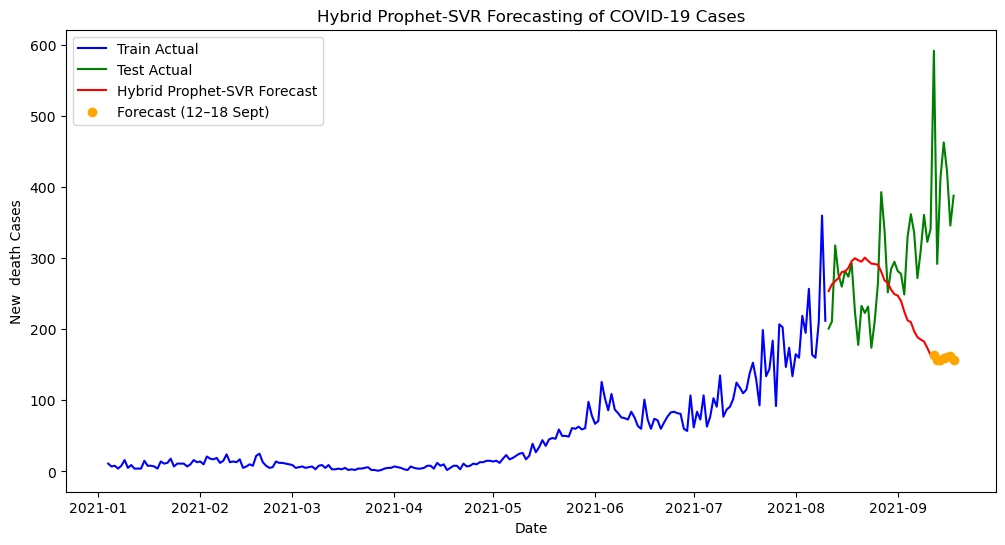

In [11]:
# =========================
# Prophet + SVR Hybrid Model with Forecasting for 12–18 Sept 2021
# =========================

import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# =========================
# 1. Load and preprocess data
# =========================
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")

# Rename columns to Prophet format
data["Date"] = pd.to_datetime(data["Date"])
data = data.rename(columns={"Date": "ds", "New deaths COVID-19 Cases": "y"})

# =========================
# 2. Train/Test split
# =========================
train = data[data["ds"] <= "2021-08-10"]   # Train until Aug 10, 2021
test  = data[data["ds"] > "2021-08-10"]    # Test from Aug 11, 2021 onward

# =========================
# 3. Fit Prophet model
# =========================
prophet = Prophet(daily_seasonality=True, yearly_seasonality=True)
prophet.fit(train)

# Forecast over the whole dataset length
future = prophet.make_future_dataframe(periods=len(test), freq="D")
prophet_forecast = prophet.predict(future)

# Align Prophet forecast with actual data
prophet_pred = prophet_forecast.set_index("ds").loc[data["ds"], "yhat"].values

# =========================
# 4. Compute residuals (Actual - Prophet)
# =========================
residuals = data["y"].values - prophet_pred
residuals_df = pd.DataFrame({"ds": data["ds"], "residuals": residuals})

# =========================
# 5. SVR on residuals
# =========================
# Create lag features for residuals (last 7 days)
for lag in range(1, 8):
    residuals_df[f"lag_{lag}"] = residuals_df["residuals"].shift(lag)

residuals_df = residuals_df.dropna().reset_index(drop=True)

# Train/Test split (same as before)
train_resid = residuals_df[residuals_df["ds"] <= "2021-08-10"]
test_resid  = residuals_df[residuals_df["ds"] > "2021-08-10"]

X_train = train_resid.drop(columns=["ds", "residuals"]).values
y_train = train_resid["residuals"].values
X_test  = test_resid.drop(columns=["ds", "residuals"]).values
y_test  = test_resid["residuals"].values

# Scale features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# Train SVR
svr = SVR(kernel="rbf", C=100, gamma=0.01, epsilon=50)
svr.fit(X_train, y_train)

# Predict residuals
resid_pred = svr.predict(X_test)

# =========================
# 6. Hybrid Forecast = Prophet + SVR residual correction
# =========================
hybrid_forecast = prophet_pred[-len(test):] + resid_pred

# =========================
# 7. Evaluation
# =========================
mse = mean_squared_error(test_series, hybrid_forecast)
mae = mean_absolute_error(test_series, hybrid_forecast)
mape = np.mean(np.abs((test_series - hybrid_forecast) / test_series)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(test_series) - np.min(test_series))
nrmse = rmse / np.mean(test_series)
r2 = r2_score(test_series, hybrid_forecast)

print("Hybrid prophet–SVR Performance:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"RRMSE: {rrmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"R²: {r2:.4f}")

# =========================
# 8. Forecast for 12–18 Sept 2021
# =========================
forecast_week = test[(test["ds"] >= "2021-09-12") & (test["ds"] <= "2021-09-18")].copy()
forecast_week["Hybrid_Forecast"] = hybrid_forecast[-len(forecast_week):]

print("\nHybrid Forecast (12–18 Sept 2021):")
print(forecast_week[["ds", "y", "Hybrid_Forecast"]])

# =========================
# 9. Plot Results
# =========================
plt.figure(figsize=(12,6))
plt.plot(train["ds"], train["y"], label="Train Actual", color="blue")
plt.plot(test["ds"], test["y"], label="Test Actual", color="green")
plt.plot(test["ds"], hybrid_forecast, label="Hybrid Prophet-SVR Forecast", color="red")

# Highlight 12–18 Sept
plt.scatter(forecast_week["ds"], forecast_week["Hybrid_Forecast"], 
            color="orange", label="Forecast (12–18 Sept)", zorder=5)

plt.legend()
plt.title("Hybrid Prophet-SVR Forecasting of COVID-19 Cases")
plt.xlabel("Date")
plt.ylabel("New  death Cases")
plt.show()


23:54:13 - cmdstanpy - INFO - Chain [1] start processing
23:54:13 - cmdstanpy - INFO - Chain [1] done processing
E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0692 - val_loss: 0.0080
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0035 - val_loss: 0.0116
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0020 - val_loss: 0.0084
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0014 - val_loss: 0.0082
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0010 - val_loss: 0.0086
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.6832e-04 - val_loss: 0.0083
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8.3492e-04 - val_loss: 0.0083
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0010 - val_loss: 0.0083
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0010 - val_loss: 0.0083
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0011 - val_loss: 0.0083
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 8.8387e-04 - val_loss: 0.0083
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

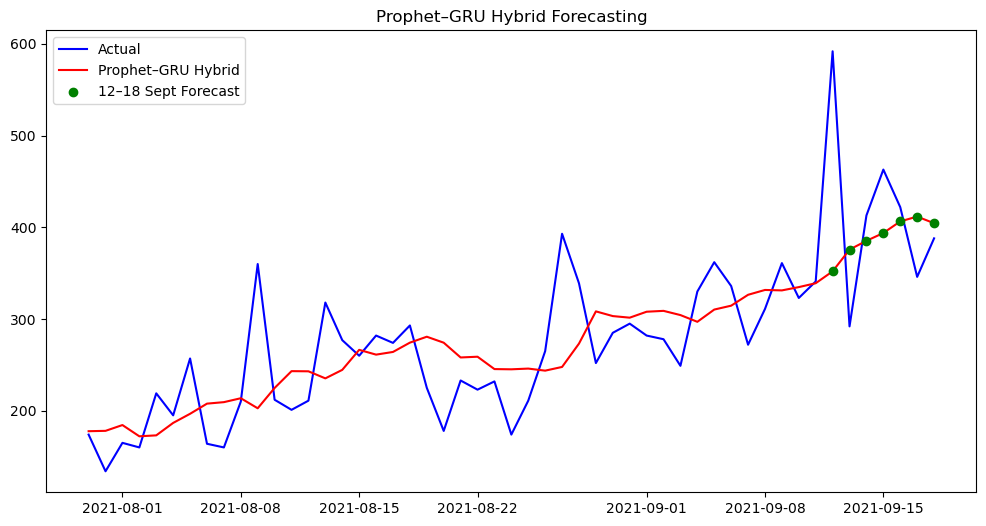

In [12]:
# =========================
# Prophet + GRU Hybrid Model
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =========================
# 1. Load data
# =========================
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
data["Date"] = pd.to_datetime(data["Date"])
data = data.rename(columns={"Date": "ds", "New deaths COVID-19 Cases": "y"})

# =========================
# 2. Fit Prophet
# =========================
prophet = Prophet()
prophet.fit(data)

# Forecast with Prophet (in-sample)
future = prophet.make_future_dataframe(periods=0)
forecast = prophet.predict(future)

# Residuals = Actual - Prophet Prediction
data["prophet_pred"] = forecast["yhat"].values
data["residuals"] = data["y"] - data["prophet_pred"]

# =========================
# 3. Prepare GRU on residuals
# =========================
scaler = MinMaxScaler()
residuals_scaled = scaler.fit_transform(data["residuals"].values.reshape(-1,1))

def create_sequences(data, seq_length=7):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 7
X, y = create_sequences(residuals_scaled, seq_length)

# Split train/test (80/20)
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for GRU [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# =========================
# 4. Build GRU model
# =========================
gru_model = Sequential()
gru_model.add(GRU(64, activation="tanh", input_shape=(seq_length,1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer="adam", loss="mse")

# Train GRU
gru_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

# Predict residuals
residuals_pred_scaled = gru_model.predict(X_test)
residuals_pred = scaler.inverse_transform(residuals_pred_scaled)

# Align Prophet predictions with GRU predictions
prophet_test = data["prophet_pred"].values[-len(residuals_pred):].reshape(-1,1)
final_pred = prophet_test + residuals_pred

# Actual values
actual = data["y"].values[-len(residuals_pred):].reshape(-1,1)

# =========================
# 5. Evaluation
# =========================
mse = mean_squared_error(actual, final_pred)
mae = mean_absolute_error(actual, final_pred)
mape = np.mean(np.abs((actual - final_pred) / actual)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(actual) - np.min(actual))
nrmse = rmse / np.mean(actual)
r2 = r2_score(actual, final_pred)

print("Hybrid Prophet–GRU Performance:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"RRMSE: {rrmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"R²: {r2:.4f}")

# =========================
# 6. Forecast extraction for 12–18 Sept 2021
# =========================
forecast_period = pd.DataFrame({
    "Date": data["ds"].values[-len(final_pred):],
    "Actual": actual.flatten(),
    "Hybrid_Forecast": final_pred.flatten()
})

week_forecast = forecast_period[
    (forecast_period["Date"] >= "2021-09-12") & 
    (forecast_period["Date"] <= "2021-09-18")
]

print("\nHybrid Prophet–GRU Forecast (12–18 Sept 2021):")
print(week_forecast)

# =========================
# 7. Plot results
# =========================
plt.figure(figsize=(12,6))
plt.plot(data["ds"].values[-len(actual):], actual, label="Actual", color="blue")
plt.plot(data["ds"].values[-len(actual):], final_pred, label="Prophet–GRU Hybrid", color="red")
plt.scatter(week_forecast["Date"], week_forecast["Hybrid_Forecast"], color="green", label="12–18 Sept Forecast", zorder=5)
plt.legend()
plt.title("Prophet–GRU Hybrid Forecasting")
plt.show()


Epoch 1/50


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.1873 - val_loss: 0.0327
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0423 - val_loss: 0.0259
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0482 - val_loss: 0.0254
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0299 - val_loss: 0.0143
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0322 - val_loss: 0.0141
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0400 - val_loss: 0.0151
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0267 - val_loss: 0.0160
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0248 - val_loss: 0.0151
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0314 - val_loss: 0.0154
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0341 - val_loss: 0.0153
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0280 - val_loss: 0.0160
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0294 - val_loss: 0.0147
Epoch 13/50


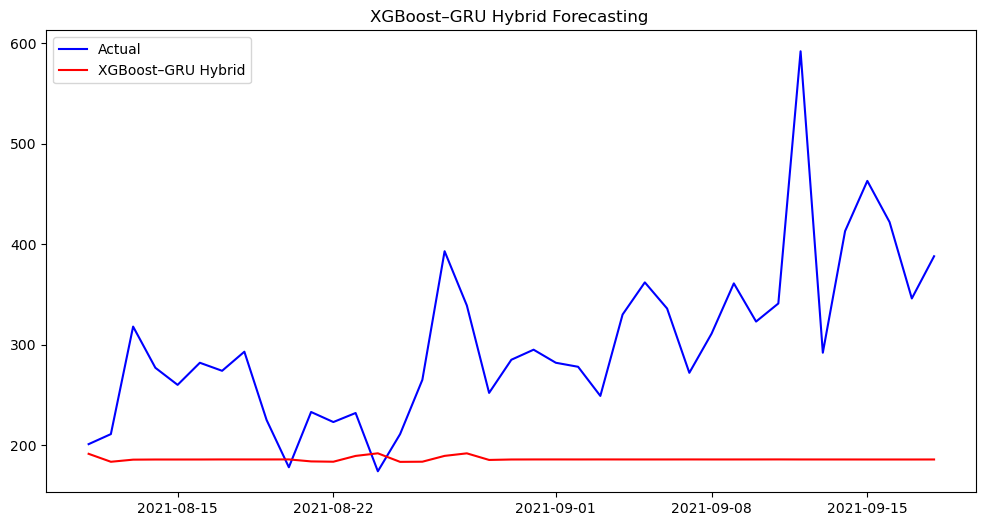


📌 Hybrid XGBoost–GRU Forecast (12–18 Sept 2021):
         Date  Actual  Hybrid_Forecast
32 2021-09-12     592       185.758392
33 2021-09-13     292       185.750854
34 2021-09-14     413       185.744965
35 2021-09-15     463       185.729187
36 2021-09-16     422       185.731613
37 2021-09-17     346       185.722549
38 2021-09-18     388       185.745697


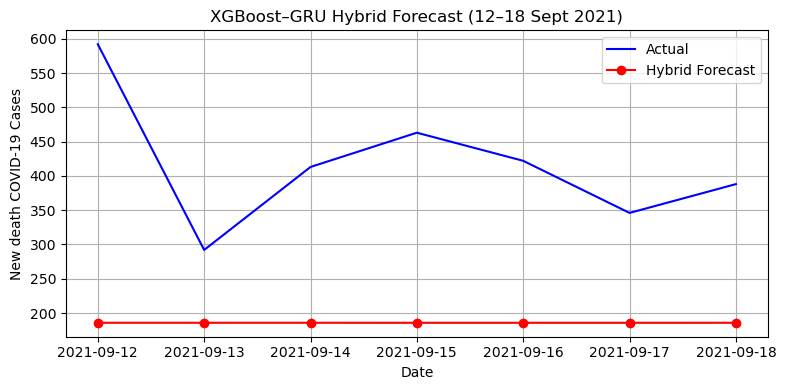

In [13]:
# =========================
# XGBoost + GRU Hybrid Model
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# =========================
# 1. Load data
# =========================
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
data["Date"] = pd.to_datetime(data["Date"])
data = data.rename(columns={"Date": "ds", "New deaths COVID-19 Cases": "y"})

# =========================
# 2. Prepare features for XGBoost
# =========================
def create_lag_features(df, col="y", lags=7):
    for lag in range(1, lags+1):
        df[f"lag_{lag}"] = df[col].shift(lag)
    return df

data = create_lag_features(data, "y", lags=7)
data = data.dropna().reset_index(drop=True)

features = [col for col in data.columns if "lag_" in col]
X = data[features].values
y = data["y"].values

# Train/test split
split = int(len(data)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# =========================
# 3. Train XGBoost baseline
# =========================
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)

# Train without early stopping (your version doesn’t support it)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# XGBoost predictions
train_pred = xgb_model.predict(X_train)
test_pred = xgb_model.predict(X_test)

# Residuals
train_resid = y_train - train_pred
test_resid = y_test - test_pred

# =========================
# 4. GRU on residuals
# =========================
scaler = MinMaxScaler()
resid_scaled = scaler.fit_transform(train_resid.reshape(-1,1))

def create_sequences(data, seq_length=7):
    X_seq, y_seq = [], []
    for i in range(len(data)-seq_length):
        X_seq.append(data[i:i+seq_length])
        y_seq.append(data[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 7
X_seq, y_seq = create_sequences(resid_scaled, seq_length)

# Train/test split for GRU
split_gru = int(len(X_seq)*0.8)
X_train_seq, X_test_seq = X_seq[:split_gru], X_seq[split_gru:]
y_train_seq, y_test_seq = y_seq[:split_gru], y_seq[split_gru:]

# Reshape for GRU
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], seq_length, 1))
X_test_seq  = X_test_seq.reshape((X_test_seq.shape[0], seq_length, 1))

# GRU model
gru_model = Sequential()
gru_model.add(GRU(64, activation="tanh", input_shape=(seq_length,1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer="adam", loss="mse")

# Train GRU
gru_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

# Predict residuals
resid_pred_scaled = gru_model.predict(X_test_seq)
resid_pred = scaler.inverse_transform(resid_pred_scaled)

# Align lengths
xgb_test_pred = test_pred[-len(resid_pred):]
final_pred = xgb_test_pred + resid_pred.flatten()
actual = y_test[-len(resid_pred):]

# =========================
# 5. Evaluation
# =========================
mse = mean_squared_error(actual, final_pred)
mae = mean_absolute_error(actual, final_pred)
mape = np.mean(np.abs((actual - final_pred) / actual)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(actual) - np.min(actual))
nrmse = rmse / np.mean(actual)
r2 = r2_score(actual, final_pred)

print("Hybrid XGBoost–GRU Performance:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"RRMSE: {rrmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"R²: {r2:.4f}")

# =========================
# 6. Plot results
# =========================
plt.figure(figsize=(12,6))
plt.plot(data["ds"].values[-len(actual):], actual, label="Actual", color="blue")
plt.plot(data["ds"].values[-len(final_pred):], final_pred, label="XGBoost–GRU Hybrid", color="red")
plt.legend()
plt.title("XGBoost–GRU Hybrid Forecasting ")
plt.show()
# =========================
# 7. Forecast for 12/09/2021 → 18/09/2021
# =========================
forecast_df = pd.DataFrame({
    "Date": data["ds"].values[-len(actual):],
    "Actual": actual,
    "Hybrid_Forecast": final_pred
})

# Select only 12–18 Sept 2021
mask = (forecast_df["Date"] >= "2021-09-12") & (forecast_df["Date"] <= "2021-09-18")
forecast_window = forecast_df.loc[mask]

print("\n📌 Hybrid XGBoost–GRU Forecast (12–18 Sept 2021):")
print(forecast_window)

# Plot zoomed window
plt.figure(figsize=(8,4))
plt.plot(forecast_window["Date"], forecast_window["Actual"], label="Actual", color="blue")
plt.plot(forecast_window["Date"], forecast_window["Hybrid_Forecast"], 
         label="Hybrid Forecast", marker="o", color="red")
plt.legend()
plt.xlabel("Date")
plt.ylabel("New death COVID-19 Cases")
plt.title("XGBoost–GRU Hybrid Forecast (12–18 Sept 2021)")
plt.grid(True)
plt.tight_layout()
plt.show()



Hybrid XGBoost–SVR Performance:
MSE: 16329.15
MAE: 99.47
MAPE: 30.91%
RMSE: 127.79
RRMSE: 0.2790
NRMSE: 0.4592
R²: -1.1117


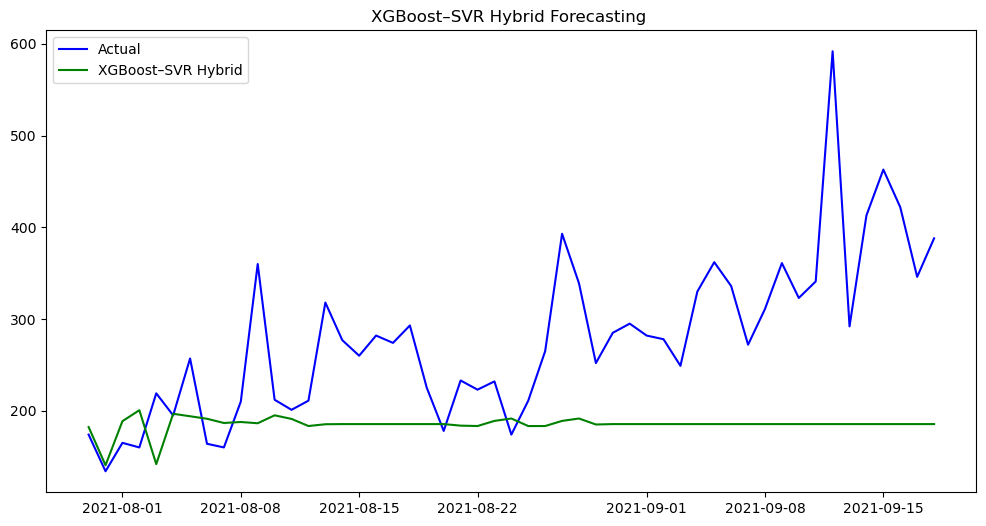

Hybrid XGBoost–SVR Forecast (12–18 Sept 2021):
          ds  Hybrid_XGB_SVR_Forecast
0 2021-09-12               185.454690
1 2021-09-13               185.454690
2 2021-09-14               185.454690
3 2021-09-15               185.014230
4 2021-09-16               191.103555
5 2021-09-17               194.444436
6 2021-09-18               194.377724


In [7]:
# =========================
# XGBoost + SVR Hybrid Model
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# =========================
# 1. Load data
# =========================
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
data["Date"] = pd.to_datetime(data["Date"])
data = data.rename(columns={"Date": "ds", "New deaths COVID-19 Cases": "y"})

# =========================
# 2. Feature engineering (lags for supervised learning)
# =========================
df = data.copy()
for lag in range(1, 8):  # last 7 days as features
    df[f"lag_{lag}"] = df["y"].shift(lag)

df = df.dropna().reset_index(drop=True)

X = df[[f"lag_{i}" for i in range(1, 8)]].values
y = df["y"].values

# Train/test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# =========================
# 3. Train XGBoost baseline
# =========================
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Predictions
xgb_train_pred = xgb_model.predict(X_train)
xgb_test_pred = xgb_model.predict(X_test)

# Residuals
residuals_train = y_train - xgb_train_pred
residuals_test = y_test - xgb_test_pred

# =========================
# 4. Train SVR on residuals
# =========================
scaler = MinMaxScaler()
residuals_scaled = scaler.fit_transform(residuals_train.reshape(-1,1)).ravel()

svr = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr.fit(X_train, residuals_scaled)

# SVR residual predictions (scaled back)
svr_resid_pred_scaled = svr.predict(X_test)
svr_resid_pred = scaler.inverse_transform(svr_resid_pred_scaled.reshape(-1,1)).ravel()

# =========================
# 5. Hybrid forecast = XGBoost + SVR residuals
# =========================
hybrid_pred = xgb_test_pred + svr_resid_pred

# =========================
# 6. Evaluation
# =========================

# =========================
# 6. Evaluation
# =========================
actual = y_test
final_pred = hybrid_pred

mse = mean_squared_error(actual, final_pred)
mae = mean_absolute_error(actual, final_pred)
mape = np.mean(np.abs((actual - final_pred) / actual)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(actual) - np.min(actual))
nrmse = rmse / np.mean(actual)
r2 = r2_score(actual, final_pred)

print("Hybrid XGBoost–SVR Performance:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"RRMSE: {rrmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"R²: {r2:.4f}")


# =========================
# 7. Plot Results
# =========================
plt.figure(figsize=(12,6))
plt.plot(df["ds"].values[train_size:], y_test, label="Actual", color="blue")
plt.plot(df["ds"].values[train_size:], hybrid_pred, label="XGBoost–SVR Hybrid", color="green")
plt.legend()
plt.title("XGBoost–SVR Hybrid Forecasting ")
plt.show()
# =========================
# Forecasting specific period: 12/09/2021 → 18/09/2021
# =========================

# Extract last known 7-day lag features **before 12 Sept 2021**
# Find the row corresponding to 11 Sept 2021
last_index = df[df['ds'] == '2021-09-11'].index[0]
last_known = df[[f"lag_{i}" for i in range(1, 8)]].iloc[last_index].values.reshape(1, -1)

forecast_dates = pd.date_range(start='2021-09-12', end='2021-09-18')
forecast_days = len(forecast_dates)

hybrid_forecast = []
current_input = last_known.copy()

for i in range(forecast_days):
    # XGBoost prediction
    xgb_pred = xgb_model.predict(current_input)[0]

    # SVR residual prediction
    svr_resid_scaled = svr.predict(current_input)[0]
    svr_resid = scaler.inverse_transform([[svr_resid_scaled]])[0][0]

    # Hybrid prediction
    hybrid_pred = xgb_pred + svr_resid
    hybrid_forecast.append(hybrid_pred)

    # Update input for next day (recursive)
    new_input = np.roll(current_input, -1)
    new_input[0, -1] = hybrid_pred
    current_input = new_input

# Put results into DataFrame
forecast_df = pd.DataFrame({
    "ds": forecast_dates,
    "Hybrid_XGB_SVR_Forecast": hybrid_forecast
})

print("Hybrid XGBoost–SVR Forecast (12–18 Sept 2021):")
print(forecast_df)


Epoch 1/50


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0052
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013   
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.1459e-04
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9539e-04
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.4692e-04
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.7233e-04 
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.1190e-04
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.4174e-04
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.1359e-04
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.2940e-04
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.9155e-04
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.9033e-04
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.5822e-04
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.6057e-04
Epoch 15/50
13/13 ━━━━━━━━━━━━━━━━━━

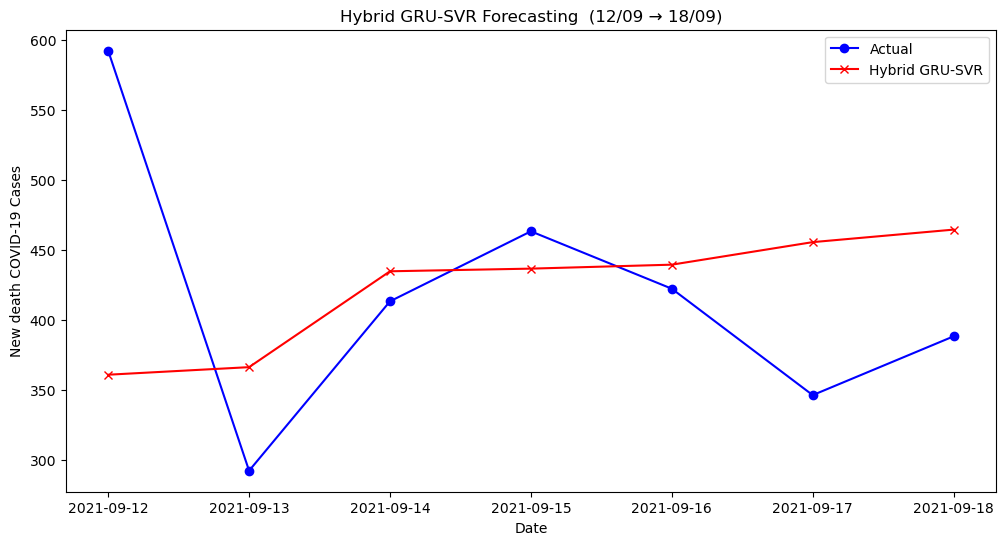

2021-09-12 - Predicted: 360, Actual: 592
2021-09-13 - Predicted: 365, Actual: 292
2021-09-14 - Predicted: 434, Actual: 413
2021-09-15 - Predicted: 436, Actual: 463
2021-09-16 - Predicted: 439, Actual: 422
2021-09-17 - Predicted: 455, Actual: 346
2021-09-18 - Predicted: 464, Actual: 388


In [9]:
# =========================
# GRU + SVR Hybrid Model (Forecast 12/09 → 18/09)
# =========================
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# =========================
# 1. Load data
# =========================
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
data['Date'] = pd.to_datetime(data['Date'])
data = data.rename(columns={"Date": "ds", "New deaths COVID-19 Cases": "y"})

# Normalize target for GRU
scaler = MinMaxScaler()
data['y_scaled'] = scaler.fit_transform(data[['y']])

# =========================
# 2. Prepare sequences for GRU
# =========================
def create_sequences(series, seq_length=7):
    X, y = [], []
    for i in range(len(series) - seq_length):
        X.append(series[i:i+seq_length])
        y.append(series[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 7
X, y = create_sequences(data['y_scaled'].values, seq_length)

# Train/test split
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for GRU [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# =========================
# 3. Build and train GRU
# =========================
gru_model = Sequential()
gru_model.add(GRU(64, activation='tanh', input_shape=(seq_length,1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# GRU predictions
gru_pred_scaled = gru_model.predict(X_test)
gru_pred = scaler.inverse_transform(gru_pred_scaled)

# =========================
# 4. Compute residuals and train SVR
# =========================
residuals = data['y'].values[-len(gru_pred):] - gru_pred.flatten()

# Create lag features for residuals
residuals_df = pd.DataFrame({'residuals': residuals})
for lag in range(1, 8):
    residuals_df[f'lag_{lag}'] = residuals_df['residuals'].shift(lag)
residuals_df = residuals_df.dropna()

X_resid = residuals_df[[f'lag_{i}' for i in range(1, 8)]].values
y_resid = residuals_df['residuals'].values

# Train/test split for SVR
split_idx = int(len(X_resid)*0.8)
X_svr_train, X_svr_test = X_resid[:split_idx], X_resid[split_idx:]
y_svr_train, y_svr_test = y_resid[:split_idx], y_resid[split_idx:]

# Train SVR
svr_model = SVR(kernel='rbf', C=100, gamma=0.01, epsilon=50)
svr_model.fit(X_svr_train, y_svr_train)

# SVR residual predictions
resid_pred = svr_model.predict(X_svr_test)

# =========================
# 5. Hybrid Forecast = GRU + SVR residuals
# =========================
hybrid_forecast = gru_pred[-len(resid_pred):].flatten() + resid_pred

# =========================
# 6. Extract forecast for 12/09 → 18/09
# =========================
forecast_dates = pd.date_range(start='2021-09-12', end='2021-09-18')
# Ensure length matches
hybrid_7days = hybrid_forecast[-7:]
actual_7days = data[data['ds'].between('2021-09-12','2021-09-18')]['y'].values

# =========================
# 7. Evaluation
# =========================
# =========================
# 7. Evaluation
# =========================
actual = actual_7days
final_pred = hybrid_7days

mse = mean_squared_error(actual, final_pred)
mae = mean_absolute_error(actual, final_pred)
mape = np.mean(np.abs((actual - final_pred) / actual)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(actual) - np.min(actual))
nrmse = rmse / np.mean(actual)
r2 = r2_score(actual, final_pred)

print("Hybrid SVR–GRU Performance (12/09 → 18/09):")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"RRMSE: {rrmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"R²: {r2:.4f}")


# =========================
# 8. Plot results
# =========================
plt.figure(figsize=(12,6))
plt.plot(forecast_dates, actual_7days, label='Actual', color='blue', marker='o')
plt.plot(forecast_dates, hybrid_7days, label='Hybrid GRU-SVR', color='red', marker='x')
plt.title('Hybrid GRU-SVR Forecasting  (12/09 → 18/09)')
plt.xlabel('Date')
plt.ylabel('New death COVID-19 Cases')
plt.legend()
plt.show()
# 6. Extract forecast for 12/09 → 18/09
# =========================
forecast_dates = pd.date_range(start='2021-09-12', end='2021-09-18')
# Ensure length matches
hybrid_7days = hybrid_forecast[-7:]
actual_7days = data[data['ds'].between('2021-09-12','2021-09-18')]['y'].values
for date, pred, actual in zip(forecast_dates, hybrid_7days, actual_7days):
    print(f"{date.date()} - Predicted: {int(pred)}, Actual: {int(actual)}")

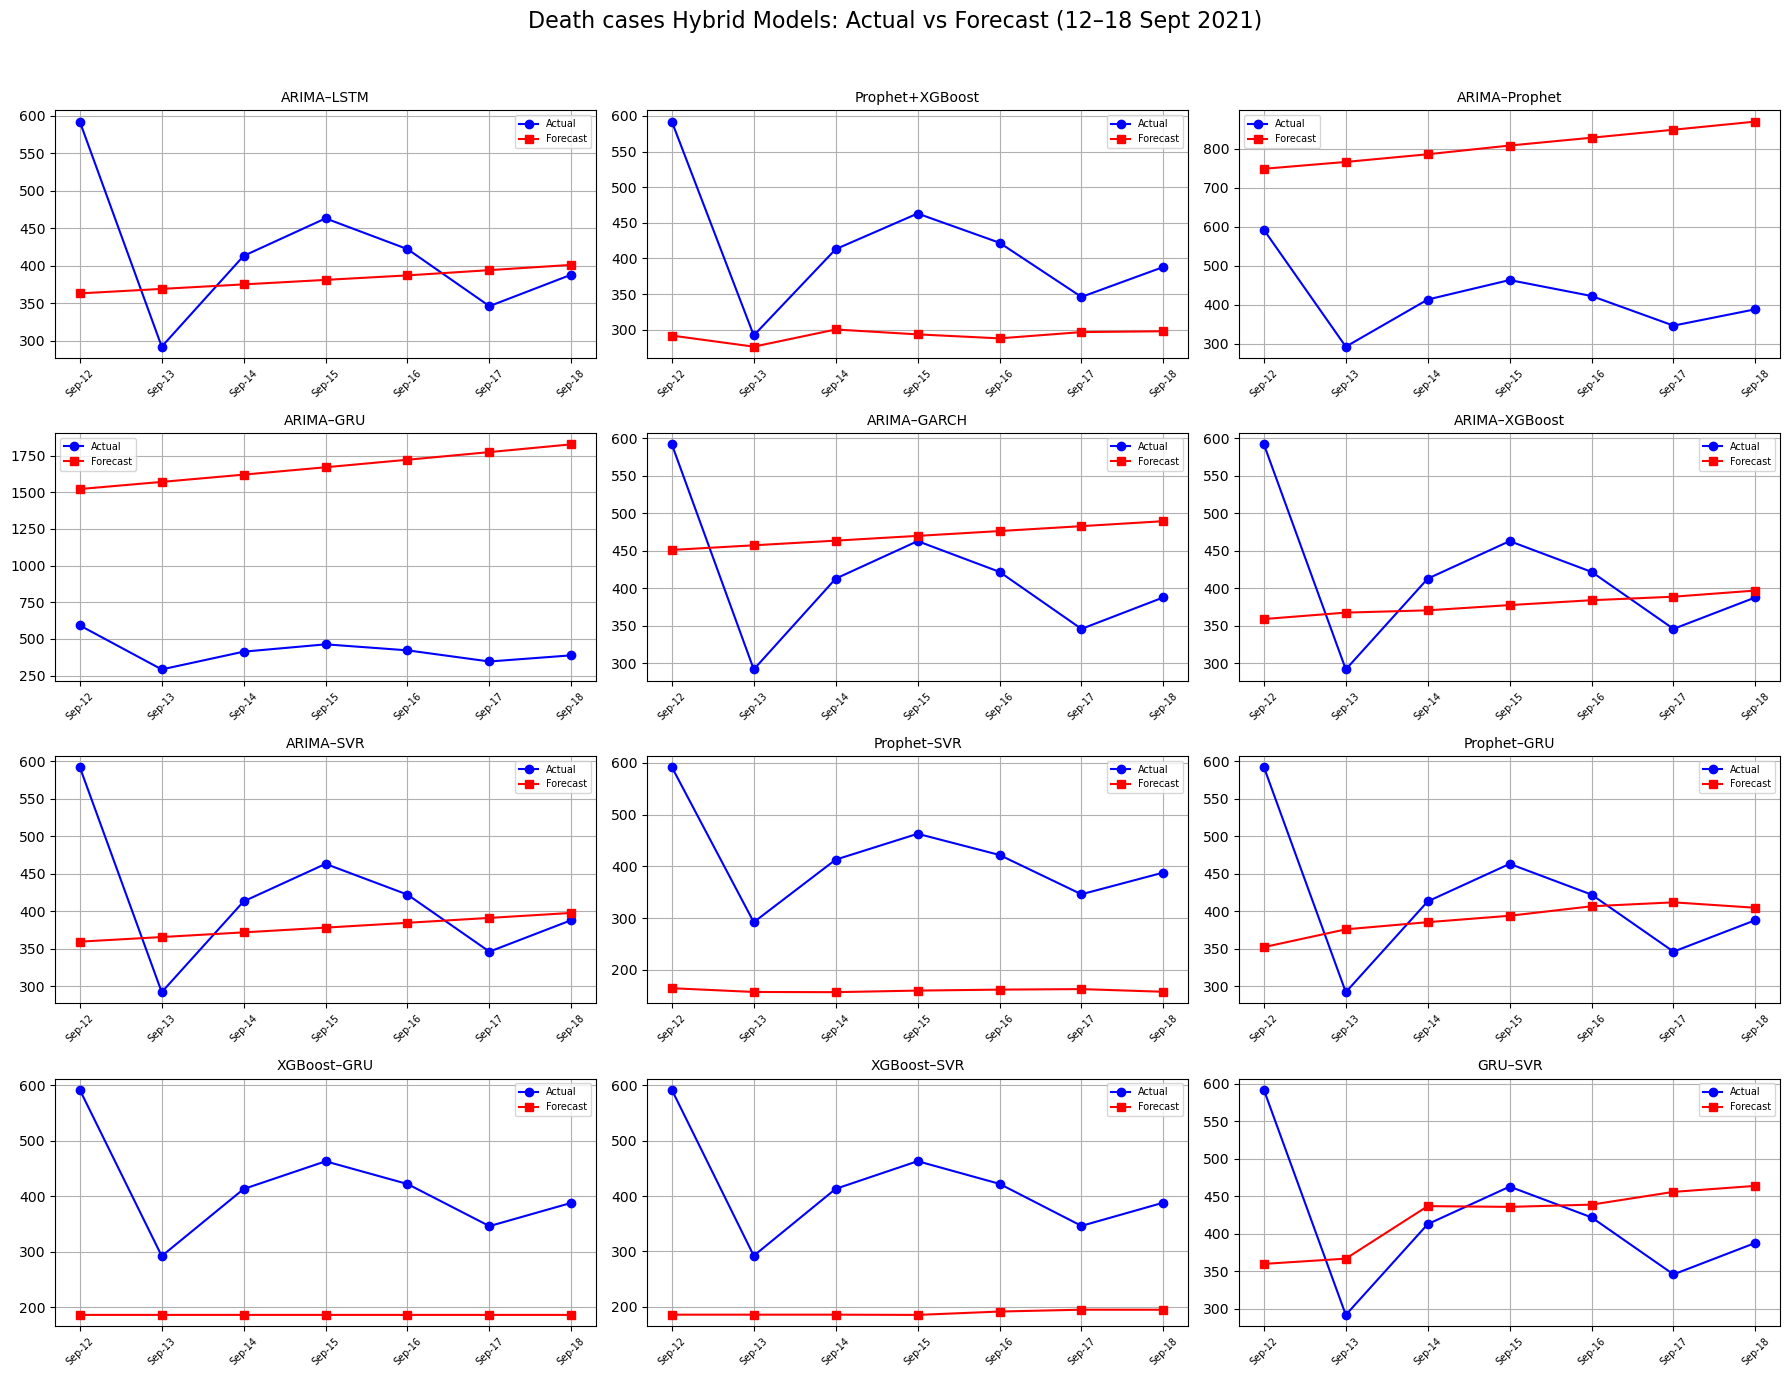

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# -----------------------------
# Step 1. Build DataFrames
# -----------------------------

dates = pd.date_range("2021-09-12", "2021-09-18")

# ARIMA–LSTM
arima_lstm = pd.DataFrame({
    "Date": dates,
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [363, 369, 375, 381, 387, 394, 401]
})

# Prophet + XGBoost
prophet_xgb = pd.DataFrame({
    "Date": dates,
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [291.76, 276.21, 300.30, 293.45, 287.85, 296.65, 297.84]
})

# ARIMA–Prophet
arima_prophet = pd.DataFrame({
    "Date": dates,
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [748.62, 766.21, 785.91, 808.30, 828.37, 848.87, 869.77]
})

# ARIMA–GRU
arima_gru = pd.DataFrame({
    "Date": dates,
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [1522.03, 1570.69, 1620.21, 1670.58, 1721.81, 1773.90, 1826.84]
})

# ARIMA–GARCH
arima_garch = pd.DataFrame({
    "Date": dates,
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [451.28, 457.42, 463.65, 469.99, 476.42, 482.95, 489.58]
})

# ARIMA–XGBoost
arima_xgb = pd.DataFrame({
    "Date": dates,
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [359.14, 367.71, 370.74, 377.74, 384.23, 388.92, 397.12]
})

# ARIMA–SVR
arima_svr = pd.DataFrame({
    "Date": dates,
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [359.33, 365.46, 371.69, 378.03, 384.46, 390.98, 397.61]
})

# Prophet–SVR
prophet_svr = pd.DataFrame({
    "Date": dates,
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [164.32, 157.03, 156.66, 159.70, 161.57, 162.58, 157.41]
})

# Prophet–GRU
prophet_gru = pd.DataFrame({
    "Date": dates,
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [352.02, 375.74, 385.30, 393.83, 406.49, 411.73, 404.50]
})

# XGBoost–GRU
xgb_gru = pd.DataFrame({
    "Date": dates,
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [185.75, 185.75, 185.74, 185.72, 185.73, 185.72, 185.74]
})

# XGBoost–SVR
xgb_svr = pd.DataFrame({
    "Date": dates,
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [185.45, 185.45, 185.45, 185.01, 191.10, 194.44, 194.37]
})

# GRU–SVR
gru_svr = pd.DataFrame({
    "Date": dates,
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [360, 367, 437, 436, 439, 456, 464]
})

# -----------------------------
# Step 2. Collect into dictionary
# -----------------------------
hybrid_models = {
    "ARIMA–LSTM": arima_lstm,
    "Prophet+XGBoost": prophet_xgb,
    "ARIMA–Prophet": arima_prophet,
    "ARIMA–GRU": arima_gru,
    "ARIMA–GARCH": arima_garch,
    "ARIMA–XGBoost": arima_xgb,
    "ARIMA–SVR": arima_svr,
    "Prophet–SVR": prophet_svr,
    "Prophet–GRU": prophet_gru,
    "XGBoost–GRU": xgb_gru,
    "XGBoost–SVR": xgb_svr,
    "GRU–SVR": gru_svr,
}

# -----------------------------
# Step 3. Individual Subplots
# -----------------------------
rows, cols = 4, 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 14))
axes = axes.flatten()

for i, (name, df) in enumerate(hybrid_models.items()):
    ax = axes[i]
    ax.plot(df["Date"], df["Actual"], marker="o", label="Actual", color="blue")
    ax.plot(df["Date"], df["Forecast"], marker="s", label="Forecast", color="red")
    ax.set_title(name, fontsize=10)
    ax.legend(fontsize=7)
    ax.grid(True)

    # fix x-axis labels
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%d"))
    ax.tick_params(axis="x", rotation=45, labelsize=7)

# remove unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Death cases Hybrid Models: Actual vs Forecast (12–18 Sept 2021)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# -----------------------------


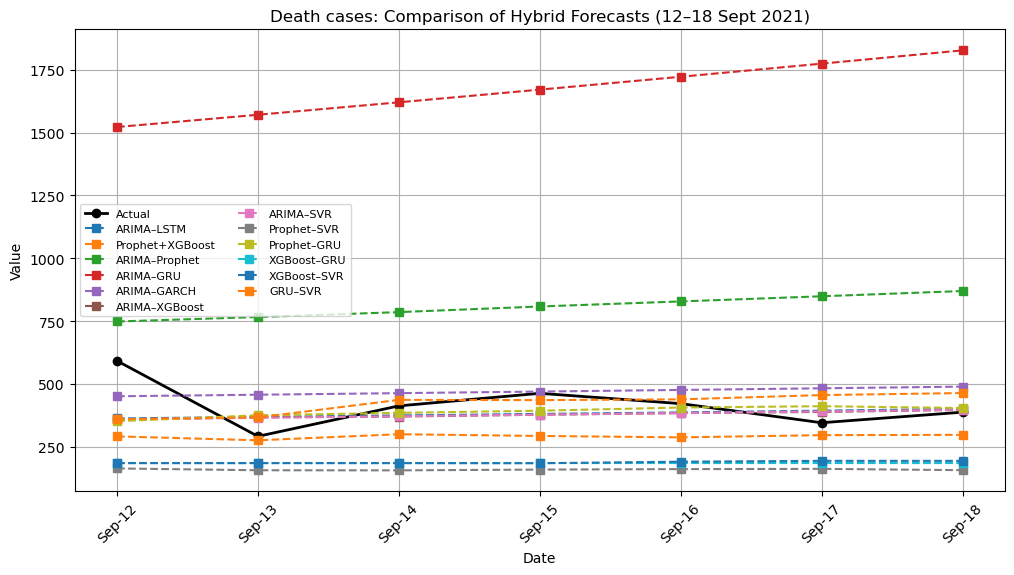

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# -----------------------------
# Step 1. Build DataFrames
# -----------------------------

dates = pd.date_range("2021-09-12", "2021-09-18")

# ARIMA–LSTM
arima_lstm = pd.DataFrame({
    "Date": dates,
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [363, 369, 375, 381, 387, 394, 401]
})

# Prophet + XGBoost
prophet_xgb = pd.DataFrame({
    "Date": dates,
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [291.76, 276.21, 300.30, 293.45, 287.85, 296.65, 297.84]
})

# ARIMA–Prophet
arima_prophet = pd.DataFrame({
    "Date": dates,
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [748.62, 766.21, 785.91, 808.30, 828.37, 848.87, 869.77]
})

# ARIMA–GRU
arima_gru = pd.DataFrame({
    "Date": dates,
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [1522.03, 1570.69, 1620.21, 1670.58, 1721.81, 1773.90, 1826.84]
})

# ARIMA–GARCH
arima_garch = pd.DataFrame({
    "Date": dates,
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [451.28, 457.42, 463.65, 469.99, 476.42, 482.95, 489.58]
})

# ARIMA–XGBoost
arima_xgb = pd.DataFrame({
    "Date": dates,
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [359.14, 367.71, 370.74, 377.74, 384.23, 388.92, 397.12]
})

# ARIMA–SVR
arima_svr = pd.DataFrame({
    "Date": dates,
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [359.33, 365.46, 371.69, 378.03, 384.46, 390.98, 397.61]
})

# Prophet–SVR
prophet_svr = pd.DataFrame({
    "Date": dates,
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [164.32, 157.03, 156.66, 159.70, 161.57, 162.58, 157.41]
})

# Prophet–GRU
prophet_gru = pd.DataFrame({
    "Date": dates,
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [352.02, 375.74, 385.30, 393.83, 406.49, 411.73, 404.50]
})

# XGBoost–GRU
xgb_gru = pd.DataFrame({
    "Date": dates,
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [185.75, 185.75, 185.74, 185.72, 185.73, 185.72, 185.74]
})

# XGBoost–SVR
xgb_svr = pd.DataFrame({
    "Date": dates,
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [185.45, 185.45, 185.45, 185.01, 191.10, 194.44, 194.37]
})

# GRU–SVR
gru_svr = pd.DataFrame({
    "Date": dates,
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [360, 367, 437, 436, 439, 456, 464]
})

# -----------------------------
# Step 2. Collect into dictionary
# -----------------------------
hybrid_models = {
    "ARIMA–LSTM": arima_lstm,
    "Prophet+XGBoost": prophet_xgb,
    "ARIMA–Prophet": arima_prophet,
    "ARIMA–GRU": arima_gru,
    "ARIMA–GARCH": arima_garch,
    "ARIMA–XGBoost": arima_xgb,
    "ARIMA–SVR": arima_svr,
    "Prophet–SVR": prophet_svr,
    "Prophet–GRU": prophet_gru,
    "XGBoost–GRU": xgb_gru,
    "XGBoost–SVR": xgb_svr,
    "GRU–SVR": gru_svr,
}

# ----------------------------
# -----------------------------
# Step 4. Combined Plot
# -----------------------------
plt.figure(figsize=(12, 6))
plt.plot(dates, [592, 292, 413, 463, 422, 346, 388], marker="o", label="Actual", color="black", linewidth=2)

for name, df in hybrid_models.items():
    plt.plot(df["Date"], df["Forecast"], marker="s", linestyle="--", label=name)

plt.title("Death cases: Comparison of Hybrid Forecasts (12–18 Sept 2021)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend(fontsize=8, ncol=2)
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b-%d"))
plt.xticks(rotation=45)

plt.show()
